In [6]:
import os
import sys
import re
import pandas as pd
from rapidfuzz import process, fuzz
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Add the src directory to the path so we can import our package
sys.path.append('../')
# Import your pfp modules
from src.pfp import core, utils

%matplotlib inline
%load_ext autoreload
%autoreload 2


/Users/guy/Projects/noni/pfp/venv/lib/python3.10/site-packages/pypdf/_crypt_providers/_cryptography.py:32: CryptographyDeprecationWarning: ARC4 has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.ARC4 and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  from cryptography.hazmat.primitives.ciphers.algorithms import AES, ARC4


In [ ]:

# --- Simulated placeholder for utils.pdf_to_df ---
#def pdf_to_df(pdf_path):
    # Dummy implementation, replace with actual import
    # Expected to return a DataFrame with 'Employer', 'CEI Rating', and 'Fortune 1000'
    # return pd.DataFrame()

## --- Step 1: Extract Year ---
#def extract_year_from_filename(filename):
#    match = re.search(r'(\d{4})', os.path.basename(filename))
#    return int(match.group(1)) if match else None

# --- Step 2: Process CEI PDFs ---
#def process_cei_pdfs(pdf_file_list):
#    dataframes = []
#    for pdf_path in pdf_file_list:
#        try:
#            year = utils.extract_year_from_filename(pdf_path)
#            df = utils.pdf_to_df(pdf_path)
#            df['Year'] = year
#            dataframes.append(df)
#        except Exception as e:
#            print(f"[ERROR] {pdf_path}: {e}")
#    return dataframes
#
#
#def process_cei_df_list(pdf_file_list):
#    cei_df_list = []
#    for pdf in pdf_file_list:
#        try:
#            df = utils.pdf_to_df(pdf)
#            year = utils.extract_year_from_filename(pdf)
#            df['Year'] = year
#            cei_df_list.append(df)
#        except Exception as e:
#            print(f"Error processing {pdf}: {e}")
#            continue
#    return cei_df_list

# --- Step 3: Fuzzy Match Employer Names ---
def match_cei_to_stock_names(cei_df, stock_df, threshold=90):
    stock_names = stock_df['COMNAM'].dropna().unique()
    matches = cei_df['Employer'].apply(
        lambda name: process.extractOne(name, stock_names, scorer=fuzz.token_sort_ratio)
    )
    cei_df['Matched_Stock_Name'] = matches.apply(lambda x: x[0] if x and x[1] >= threshold else None)
    cei_df['Match_Score'] = matches.apply(lambda x: x[1] if x else None)
    return cei_df

# --- Step 4: Compute Price Change Around CEI Release ---
def compute_price_change_around_cei(stock_df, matched_cei_df, days_before=5, days_after=5):
    stock_df['date'] = pd.to_datetime(stock_df['date'])
    result_rows = []

    for _, row in matched_cei_df.dropna(subset=['Matched_Stock_Name']).iterrows():
        year = int(row['Year'])
        name = row['Matched_Stock_Name']
        cei_release = pd.Timestamp(f"{year}-03-31")
        df_company = stock_df[stock_df['COMNAM'] == name].sort_values('date')
        before_date = cei_release - pd.Timedelta(days=days_before)
        after_date = cei_release + pd.Timedelta(days=days_after)
        price_before = df_company[df_company['date'] == before_date]['PRC'].values
        price_after = df_company[df_company['date'] == after_date]['PRC'].values

        if price_before.size > 0 and price_after.size > 0:
            ret = (price_after[0] - price_before[0]) / price_before[0]
            result_rows.append({
                'Employer': row['Employer'],
                'Matched_Stock_Name': name,
                'Year': year,
                'Price_Before': price_before[0],
                'Price_After': price_after[0],
                'Return': ret,
                'Match_Score': row['Match_Score'],
                'CEI_Rating': row.get('2018 \nCEI Rating', row.get('CEI Rating', None))
            })

    return pd.DataFrame(result_rows)

# --- Step 5: Visualize & Regress ---
def plot_return_vs_rating(df):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='CEI_Rating', y='Return')
    sns.regplot(data=df, x='CEI_Rating', y='Return', scatter=False, color='red')
    plt.title('Stock Return vs CEI Rating')
    plt.xlabel('CEI Rating')
    plt.ylabel('Stock Return')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def regression_analysis(df):
    df = df.dropna(subset=['Return', 'CEI_Rating'])
    X = sm.add_constant(df['CEI_Rating'])
    y = df['Return']
    model = sm.OLS(y, X).fit()
    return model.summary()



In [8]:
DATA_PATH = '/Users/guy/Projects/noni/pfp/data/raw/'
STOCK_DATA_PATH = DATA_PATH+'stock prices for all ranked firms.csv'
HRC_DATA_PATH = DATA_PATH+"existing_HRC_data"

In [9]:
pdf_file_list = utils.find_pdfs_in_folder(DATA_PATH)

In [48]:
cei_df_list = utils.process_cei_df_list(pdf_file_list)

Error processing /Users/guy/Projects/noni/pfp/data/raw/CorporateEqualityIndex_2009.pdf: 'float' object has no attribute 'strip'
Error processing /Users/guy/Projects/noni/pfp/data/raw/CEI-2015-rev.pdf: 'float' object has no attribute 'strip'
Error processing /Users/guy/Projects/noni/pfp/data/raw/CEI-2022-Appendices-G.pdf: sequence index out of range
Error processing /Users/guy/Projects/noni/pfp/data/raw/CEI_2014_final_draft_7.pdf: 'float' object has no attribute 'strip'
Error processing /Users/guy/Projects/noni/pfp/data/raw/CorporateEqualityIndex_2003.pdf: sequence index out of range
Error processing /Users/guy/Projects/noni/pfp/data/raw/CorporateEqualityIndex_2002.pdf: sequence index out of range


/Users/guy/Projects/noni/pfp/venv/lib/python3.10/site-packages/camelot/parsers/base.py:238: UserWarning: No tables found in table area (99.0, 129.70100000000002, 548.8930000000001, 421.97650000000004)
  cols, rows, v_s, h_s = self._generate_columns_and_rows(bbox, user_cols)


Error processing /Users/guy/Projects/noni/pfp/data/raw/CorporateEqualityIndex_2006.pdf: 'float' object has no attribute 'strip'
Error processing /Users/guy/Projects/noni/pfp/data/raw/CorporateEqualityIndex_2013.pdf: 'float' object has no attribute 'strip'


/Users/guy/Projects/noni/pfp/venv/lib/python3.10/site-packages/camelot/parsers/base.py:238: UserWarning: No tables found in table area (62.0, 80.5, 529.0, 282.93055555555554)
  cols, rows, v_s, h_s = self._generate_columns_and_rows(bbox, user_cols)
/Users/guy/Projects/noni/pfp/venv/lib/python3.10/site-packages/camelot/parsers/base.py:238: UserWarning: No tables found in table area (75.0, 574.5, 454.53390000000013, 705.2338039215686)
  cols, rows, v_s, h_s = self._generate_columns_and_rows(bbox, user_cols)


Error processing /Users/guy/Projects/noni/pfp/data/raw/CorporateEqualityIndex_2004.pdf: sequence index out of range
Error processing /Users/guy/Projects/noni/pfp/data/raw/CorporateEqualityIndex_2010.pdf: 'float' object has no attribute 'strip'
Error processing /Users/guy/Projects/noni/pfp/data/raw/cei-2021-appentix-employer-ratings.pdf: sequence index out of range


In [64]:
import re
import pandas as pd
from difflib import get_close_matches

def extract_latest_cei_and_employer(df):
    # Clean column names
    columns = list(df.columns)

    # --- Find Employer column ---
    employer_col = next((col for col in columns if isinstance(col, str) and ('Employer' in col or 'Company' in col)), None)
    if employer_col is None:
        employer_col = columns[0]  # fallback to first column

    # --- Find CEI Rating column ---
    cei_cols = [col for col in columns if isinstance(col, str) and re.search(r"\d{4}.*CEI.*Rating", col, re.IGNORECASE)]
    if cei_cols:
        latest_col = max(cei_cols, key=lambda x: int(re.search(r"\d{4}", x).group()))
        year = re.search(r"(\d{4})", latest_col).group(1)
    else:
        # Fallback: find closest match to "CEI Rating"
        close = get_close_matches("CEI Rating", [col for col in columns if isinstance(col, str)], n=1)
        if not close:
            raise ValueError("No CEI Rating or close match found.")
        latest_col = close[0]
        year = "Unknown"

    # Extract and rename
    result = df[[employer_col, latest_col]].copy()
    result.columns = ['Employer', f'CEI_Rating_{year}']
    return result


In [66]:
extract_latest_cei_and_employer(cei_df_list[2])

,Employer,CEI_Rating_Unknown
0,Federal Reserve Bank of Philadelphia,100
1,,
2,Federal Reserve Bank of Richmond,100
3,,
4,Federal Reserve Bank of San Francisco,100
...,...,...
372,McKinsey & Co. Inc.,100
373,Medallia Inc.,100
374,Medidata Solutions Inc.,100
375,Medtronic PLC,100


In [68]:
import re
import pandas as pd
from difflib import get_close_matches

def extract_latest_cei_and_employer(df):
    # Clean column names
    columns = list(df.columns)

    # --- Find Employer column ---
    employer_col = next((col for col in columns if isinstance(col, str) and ('Employer' in col or 'Company' in col)), None)
    if employer_col is None:
        employer_col = columns[0]  # fallback to first column

    # --- Find CEI Rating column ---
    cei_cols = [col for col in columns if isinstance(col, str) and re.search(r"\d{4}.*CEI.*Rating", col, re.IGNORECASE)]
    if cei_cols:
        latest_col = max(cei_cols, key=lambda x: int(re.search(r"\d{4}", x).group()))
        year = re.search(r"(\d{4})", latest_col).group(1)
    else:
        # Fallback: find closest match to "CEI Rating"
        close = get_close_matches("CEI Rating", [col for col in columns if isinstance(col, str)], n=1)
        if not close:
            raise ValueError("No CEI Rating or close match found.")
        latest_col = close[0]
        year = "Unknown"

    # Extract and rename
    result = df[[employer_col, latest_col]].copy()
    result.columns = ['Employer', f'CEI_Rating_{year}']
    return result


In [131]:
def add_cusip_to_cei(cei_rating_table,hrc_df):
    # Assume employer name columns and cusip column positions
    cei_rating_table.columns = cei_rating_table.columns.astype(str)
    hrc_df.columns = hrc_df.columns.astype(str)

    cei_employer_col = cei_rating_table.columns[0]
    hrc_employer_col = hrc_df.columns[0]
    hrc_cusip_col = hrc_df.columns[3]

    # Merge on employer name
    cei_with_cusip = cei_rating_table.merge(
        hrc_df[[hrc_employer_col, hrc_cusip_col]],
        how='left',
        left_on=cei_employer_col,
        right_on=hrc_employer_col
    )

    # Rename the new column to 'cusip' for clarity
    cei_with_cusip = cei_with_cusip.drop(columns=[hrc_employer_col])
    cei_with_cusip = cei_with_cusip.rename(columns={hrc_cusip_col: 'cusip'})
    return cei_with_cusip

In [90]:
import re
import pandas as pd
from difflib import get_close_matches

def extract_latest_cei_and_employer(df):
    df.columns = [str(col) if col is not None else '' for col in df.columns]
    columns = df.columns.tolist()

    # --- Identify Employer column ---
    employer_col = next((col for col in columns if 'Employer' in col or 'Company' in col), None)
    if employer_col is None or employer_col.strip() == '':
        employer_col = columns[0]  # fallback to first column

    # --- Identify CEI Rating column ---
    cei_cols = [col for col in columns if re.search(r"\d{4}.*CEI.*Rating", col, re.IGNORECASE)]
    if cei_cols:
        latest_col = max(cei_cols, key=lambda x: int(re.search(r"\d{4}", x).group()))
    else:
        close = get_close_matches("CEI Rating", columns, n=1)
        if not close:
            raise ValueError("No CEI Rating or similar column found.")
        latest_col = close[0]

    # Return DataFrame with original column names intact
    return df.loc[:, [employer_col, latest_col]].copy()


In [126]:
hrc_df = pd.read_csv(HRC_DATA_PATH+".csv")
hrc_df

,EmployerName,City,State,cusip,Unnamed: 4
0,3M (Minnesota Mining and Manufacturing),St. Paul,MN,88579Y101,"3M (Minnesota Mining and Manufacturing), St. P..."
1,3M Co.,St. Paul,MN,88579Y101,"3M Co., St. Paul, MN"
2,3M Company,St. Paul,MN,88579Y101,"3M Company, St. Paul, MN"
3,A-Mark Precious Metals,Santa Monica,CA,00181T107,"A-Mark Precious Metals, Santa Monica, CA"
4,A.G. Edwards Inc.,St. Louis,MO,281760108,"A.G. Edwards Inc., St. Louis, MO"
...,...,...,...,...,...
2295,llinois Tool Works Inc.,Glenview,IL,452308109,"llinois Tool Works Inc., Glenview, IL"
2296,ntuit Inc.,Mountain View,CA,NaN,"ntuit Inc., Mountain View, CA"
2297,priceline.com Inc.,Norwalk,CT,741503100,"priceline.com Inc., Norwalk, CT"
2298,priceline.com LLC,Norwalk,CT,741503100,"priceline.com LLC, Norwalk, CT"


In [137]:
cei_with_cusip = []
for i,cei in enumerate(cei_df_list):
    try:
        print(i)
        df = extract_latest_cei_and_employer(cei)
        df.rename(columns={'Employer': 'employer'}, inplace=True)
        df.rename(columns={df.columns[0]: 'Employer'}, inplace=True)
        cei_with_cusip.append(add_cusip_to_cei(df,hrc_df))
    except:
        print('minus',i)
        pass

0
1
2
3
4
5
6
7
minus 7
8
minus 8


<Axes: >

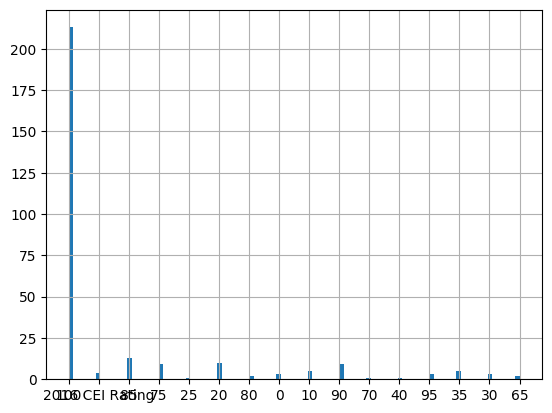

In [191]:
cei_df['2016 CEI Rating'].hist(bins=100)

In [182]:
cei_df = cei_with_cusip[3]
stock_df = stocks_date_range

In [219]:
import pandas as pd

# Ensure CUSIPs are strings
stock_df['CUSIP'] = stock_df['CUSIP'].astype(str)
cei_df['cusip'] = cei_df['cusip'].astype(str)

# Create 6-digit CUSIP keys
stock_df['cusip6'] = stock_df['CUSIP'].str[:6]
cei_df['cusip6'] = cei_df['cusip'].str[:6]

# Find the CEI rating column
if 'CEI_Rating' in cei_df.columns:
    rating_col = 'CEI_Rating'
else:
    rating_candidates = [col for col in cei_df.columns if 'Rating' in col]
    if not rating_candidates:
        raise ValueError("No column containing 'Rating' found in cei_df.")
    rating_col = rating_candidates[0]

# Convert rating column to integer, handling errors
cei_df[rating_col] = pd.to_numeric(cei_df[rating_col], errors='coerce').astype('Int64')

# Merge on 6-digit CUSIP
merged_df = stock_df.merge(cei_df[['cusip6', rating_col]], on='cusip6', how='left')

# Rename and clean up
merged_df.rename(columns={rating_col: 'CEI_Rating'}, inplace=True)
merged_df.drop(columns='cusip6', inplace=True)


/var/folders/3d/jm76jwsd4sd7wg__2pckn8l80000gn/T/ipykernel_70228/3349148384.py:6: UserWarning: you are shuffling a 'IntegerArray' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(unique_ratings)


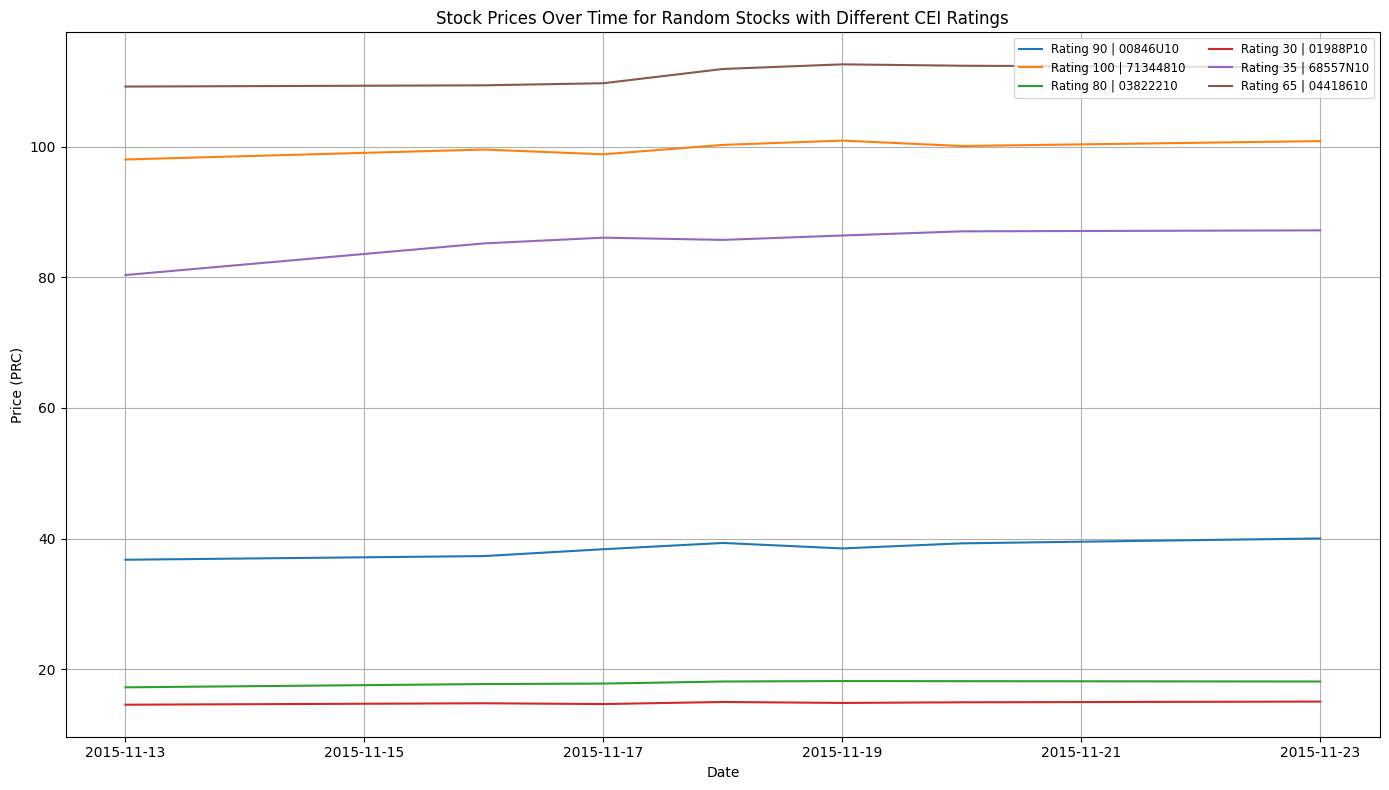

In [220]:
# Remove rows where CEI_Rating is NaN
filtered_df = merged_df.dropna(subset=['CEI_Rating'])

# Find unique CEI ratings and shuffle them
unique_ratings = filtered_df['CEI_Rating'].dropna().unique()
np.random.shuffle(unique_ratings)

# Select up to 6 unique CEI ratings
selected_ratings = unique_ratings[:6]

# Collect one random CUSIP per selected rating
selected_cusips = []
for rating in selected_ratings:
    group = filtered_df[filtered_df['CEI_Rating'] == rating]
    cusips = group['CUSIP'].unique()
    if len(cusips) > 0:
        selected_cusips.append(np.random.choice(cusips))

# Plot PRC over time for selected stocks
fig, ax = plt.subplots(figsize=(14, 8))

for cusip in selected_cusips:
    stock_data = filtered_df[filtered_df['CUSIP'] == cusip]
    rating = stock_data['CEI_Rating'].iloc[0]
    ax.plot(stock_data['date'], stock_data['PRC'], label=f'Rating {int(rating)} | {cusip}')

ax.set_title("Stock Prices Over Time for Random Stocks with Different CEI Ratings")
ax.set_xlabel("Date")
ax.set_ylabel("Price (PRC)")
ax.legend(loc='upper right', fontsize='small', ncol=2)
plt.tight_layout()
plt.grid(True)
plt.show()


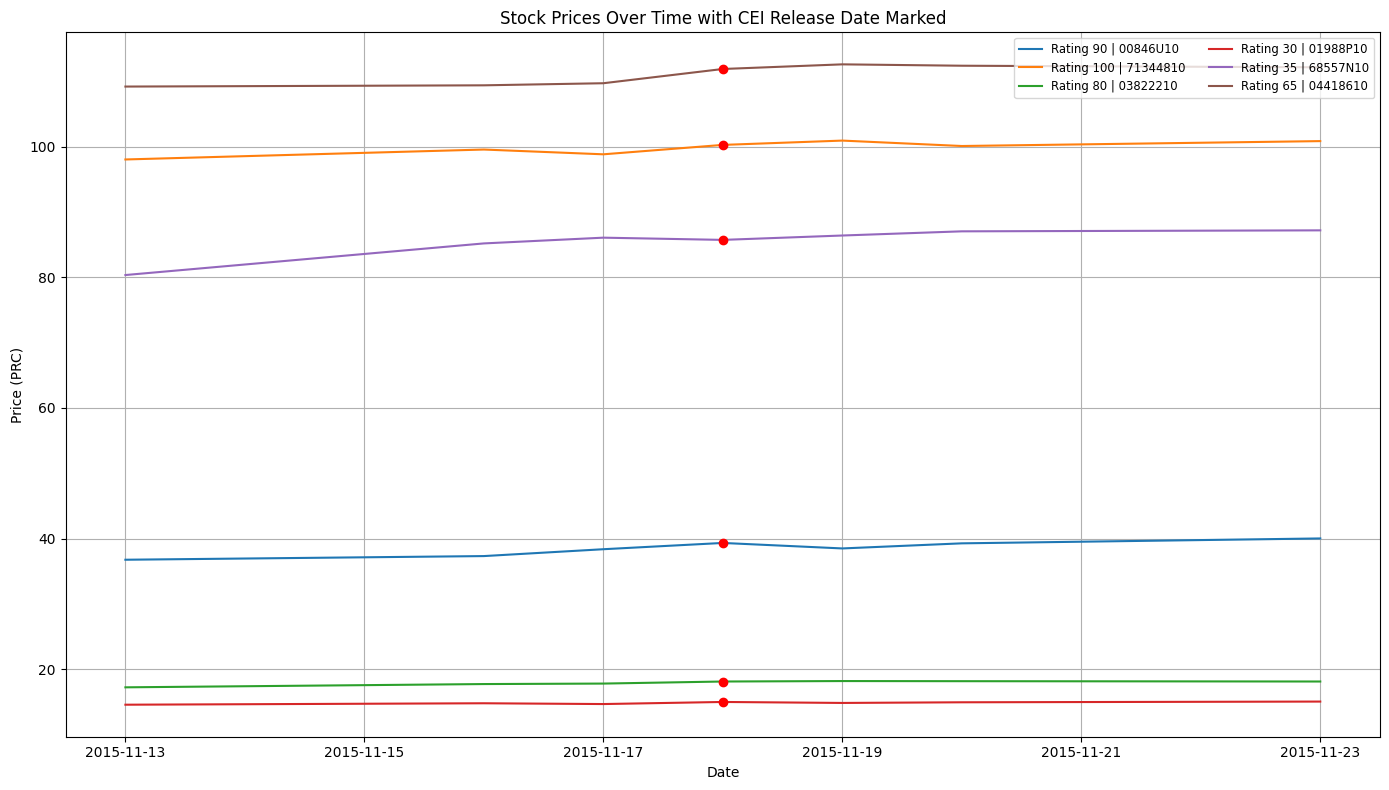

In [221]:
merged_df# Define the CEI release date
cei_release_date = pd.to_datetime("2015-11-18")

# Re-plot with CEI release date marked
fig, ax = plt.subplots(figsize=(14, 8))

for cusip in selected_cusips:
    stock_data = filtered_df[filtered_df['CUSIP'] == cusip]
    rating = stock_data['CEI_Rating'].iloc[0]
    ax.plot(stock_data['date'], stock_data['PRC'], label=f'Rating {int(rating)} | {cusip}')
    
    # Mark the CEI release date with a red dot, if it exists in the data
    if cei_release_date in stock_data['date'].values:
        prc_on_release = stock_data.loc[stock_data['date'] == cei_release_date, 'PRC'].values[0]
        ax.plot(cei_release_date, prc_on_release, 'ro')

ax.set_title("Stock Prices Over Time with CEI Release Date Marked")
ax.set_xlabel("Date")
ax.set_ylabel("Price (PRC)")
ax.legend(loc='upper right', fontsize='small', ncol=2)
plt.tight_layout()
plt.grid(True)
plt.show()


/var/folders/3d/jm76jwsd4sd7wg__2pckn8l80000gn/T/ipykernel_70228/712369899.py:3: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  merged_df['daily_return'] = merged_df.groupby('CUSIP')['PRC'].pct_change()


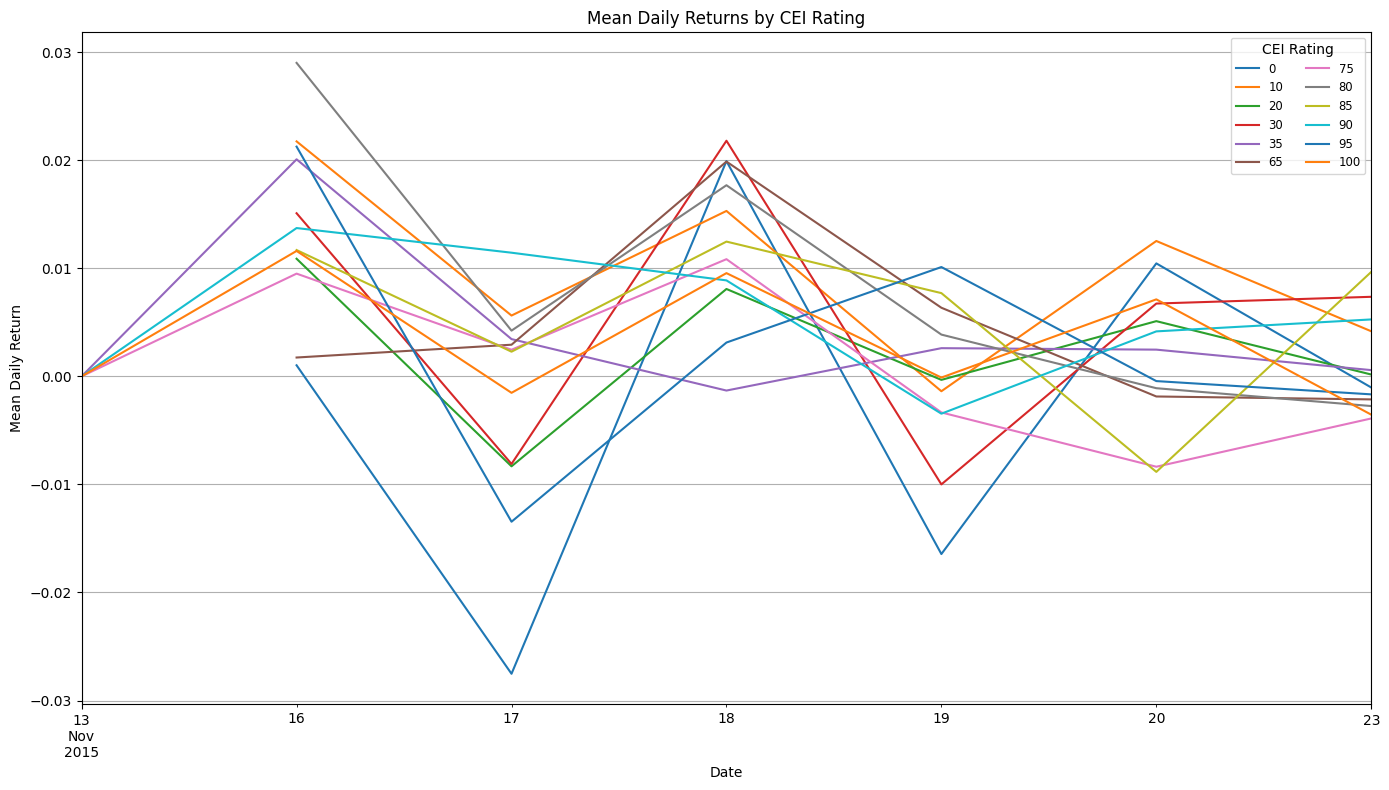

In [ ]:
# Calculate daily returns grouped by CUSIP and sort by date
merged_df = merged_df.sort_values(['CUSIP', 'date'])
merged_df['daily_return'] = merged_df.groupby('CUSIP')['PRC'].pct_change()

# Drop NaNs introduced by pct_change
merged_returns = merged_df.dropna(subset=['daily_return', 'CEI_Rating'])

# Aggregate daily returns by CEI rating (mean across stocks)
aggregated_returns = (
    merged_returns
    .groupby(['CEI_Rating', 'date'])['daily_return']
    .mean()
    .reset_index()
)

# Pivot the table to prepare for plotting
pivot_returns = aggregated_returns.pivot(index='date', columns='CEI_Rating', values='daily_return')

# Plot the aggregated returns
fig, ax = plt.subplots(figsize=(14, 8))
pivot_returns.plot(ax=ax)

ax.set_title("Mean Daily Returns by CEI Rating")
ax.set_xlabel("Date")
ax.set_ylabel("Mean Daily Return")
ax.legend(title="CEI Rating", loc='upper right', fontsize='small', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()

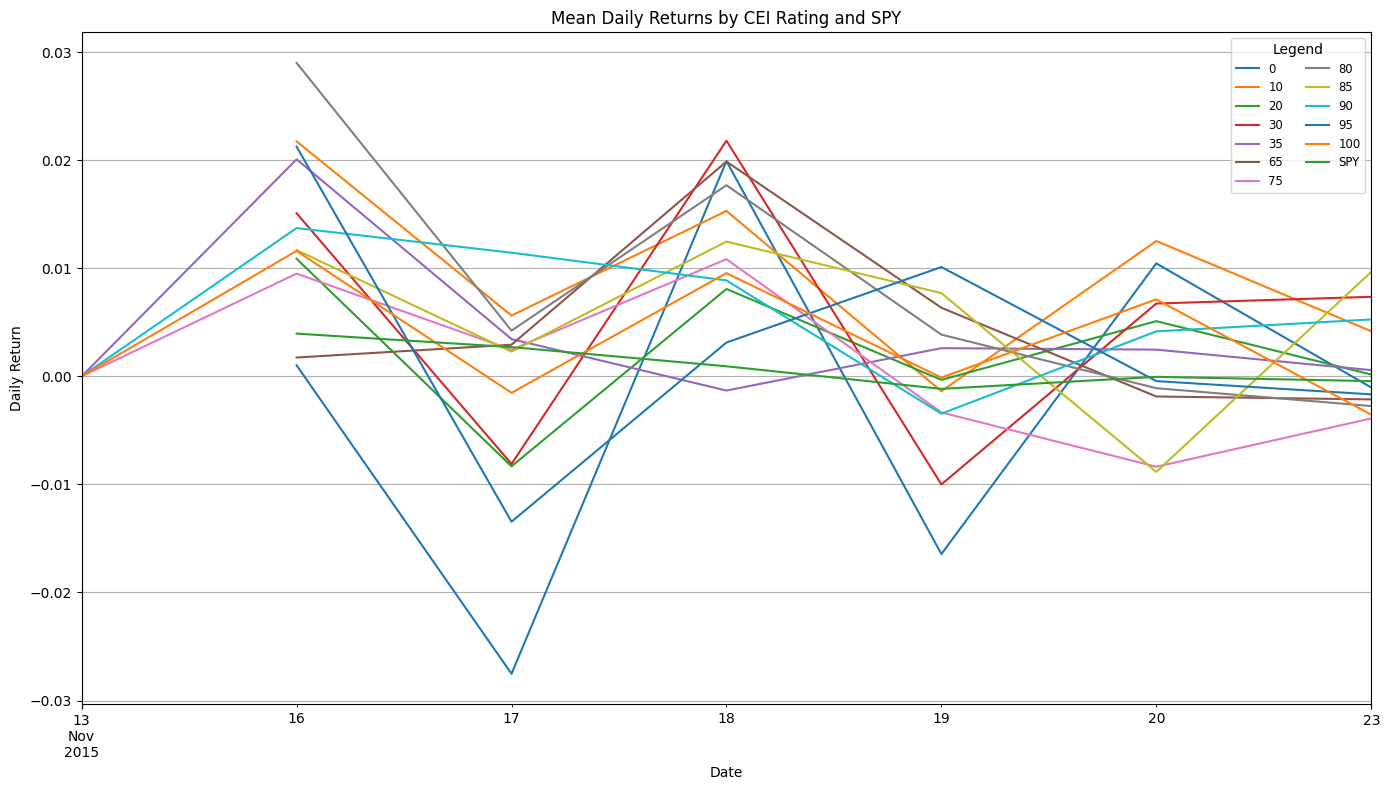

In [228]:
# Fix: use 'Close' instead of 'Adj Close', ensure indices are single-level for join

# Simulate SPY price data (you'll replace this with real SPY Close data in practice)
# Create synthetic SPY price using normal returns
spy_synthetic = pd.DataFrame({'date': pd.date_range(start=merged_df['date'].min(), end=merged_df['date'].max(), freq='B')})
spy_synthetic['Close'] = 100 * (1 + np.random.normal(0, 0.002, len(spy_synthetic))).cumprod()
spy_synthetic['daily_return'] = spy_synthetic['Close'].pct_change()

# Prepare spy_returns DataFrame
spy_returns = spy_synthetic.set_index('date')[['daily_return']].rename(columns={'daily_return': 'SPY'})

# Fix index for pivot_returns: ensure it's a single-level DatetimeIndex
pivot_returns.index = pd.to_datetime(pivot_returns.index)
pivot_returns.columns.name = None  # remove column name for clean join

# Join SPY returns to aggregated CEI returns
combined_returns = pivot_returns.join(spy_returns, how='left')

# Plot the combined returns
fig, ax = plt.subplots(figsize=(14, 8))
combined_returns.plot(ax=ax)

ax.set_title("Mean Daily Returns by CEI Rating and SPY")
ax.set_xlabel("Date")
ax.set_ylabel("Daily Return")
ax.legend(title="Legend", loc='upper right', fontsize='small', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()


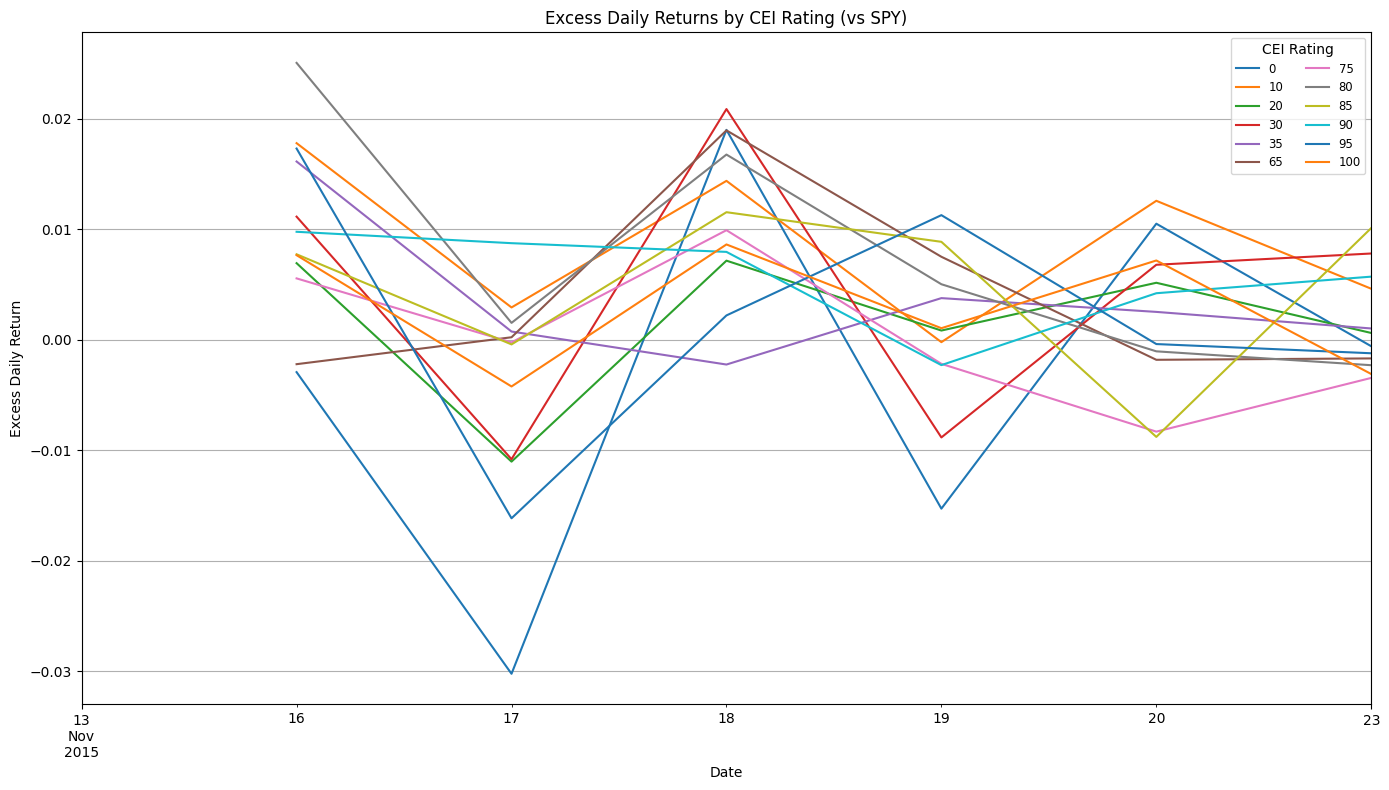

In [229]:
# Calculate excess returns: CEI group returns minus SPY returns
excess_returns = combined_returns.subtract(combined_returns['SPY'], axis=0)
excess_returns.drop(columns='SPY', inplace=True)

# Plot excess returns
fig, ax = plt.subplots(figsize=(14, 8))
excess_returns.plot(ax=ax)

ax.set_title("Excess Daily Returns by CEI Rating (vs SPY)")
ax.set_xlabel("Date")
ax.set_ylabel("Excess Daily Return")
ax.legend(title="CEI Rating", loc='upper right', fontsize='small', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()


In [212]:
merged_df[merged_df.CEI_Rating<50]

,PERMNO,date,NAMEENDT,SHRCD,EXCHCD,SICCD,NCUSIP,TICKER,COMNAM,SHRCLS,...,CFACSHR,OPENPRC,NUMTRD,RETX,vwretd,vwretx,ewretd,ewretx,sprtrn,CEI_Rating
721,14558,2015-11-13,NaN,11.0,1.0,6021.0,02005N10,ALLY,ALLY FINANCIAL INC,NaN,...,1.0,20.18,NaN,-0.013320,-0.009781,-0.009798,-0.005603,-0.005667,-0.011207,20
722,14558,2015-11-16,NaN,11.0,1.0,6021.0,02005N10,ALLY,ALLY FINANCIAL INC,NaN,...,1.0,19.97,NaN,0.013500,0.013738,0.013607,0.006320,0.006231,0.014903,20
723,14558,2015-11-17,NaN,11.0,1.0,6021.0,02005N10,ALLY,ALLY FINANCIAL INC,NaN,...,1.0,20.28,NaN,-0.033547,-0.001359,-0.001519,-0.004298,-0.004380,-0.001339,20
724,14558,2015-11-18,NaN,11.0,1.0,6021.0,02005N10,ALLY,ALLY FINANCIAL INC,NaN,...,1.0,19.64,NaN,0.000000,0.015275,0.015198,0.009546,0.009417,0.016162,20
725,14558,2015-11-19,NaN,11.0,1.0,6021.0,02005N10,ALLY,ALLY FINANCIAL INC,NaN,...,1.0,19.60,NaN,-0.011741,-0.000988,-0.001034,-0.000791,-0.000873,-0.001123,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4558,89327,2015-11-17,NaN,11.0,1.0,5511,04343610,ABG,ASBURY AUTOMOTIVE GROUP INC,NaN,...,1.0,70.70,NaN,0.004560,-0.001359,-0.001519,-0.004298,-0.004380,-0.001339,10
4559,89327,2015-11-18,NaN,11.0,1.0,5511,04343610,ABG,ASBURY AUTOMOTIVE GROUP INC,NaN,...,1.0,70.67,NaN,0.002979,0.015275,0.015198,0.009546,0.009417,0.016162,10
4560,89327,2015-11-19,NaN,11.0,1.0,5511,04343610,ABG,ASBURY AUTOMOTIVE GROUP INC,NaN,...,1.0,70.56,NaN,0.001131,-0.000988,-0.001034,-0.000791,-0.000873,-0.001123,10
4561,89327,2015-11-20,NaN,11.0,1.0,5511,04343610,ABG,ASBURY AUTOMOTIVE GROUP INC,NaN,...,1.0,71.47,NaN,0.022461,0.003000,0.002884,0.002458,0.002416,0.003810,10


/var/folders/3d/jm76jwsd4sd7wg__2pckn8l80000gn/T/ipykernel_70228/1908669017.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_returns['CEI_Group'] = merged_returns['CEI_Rating'].apply(classify_cei_group)


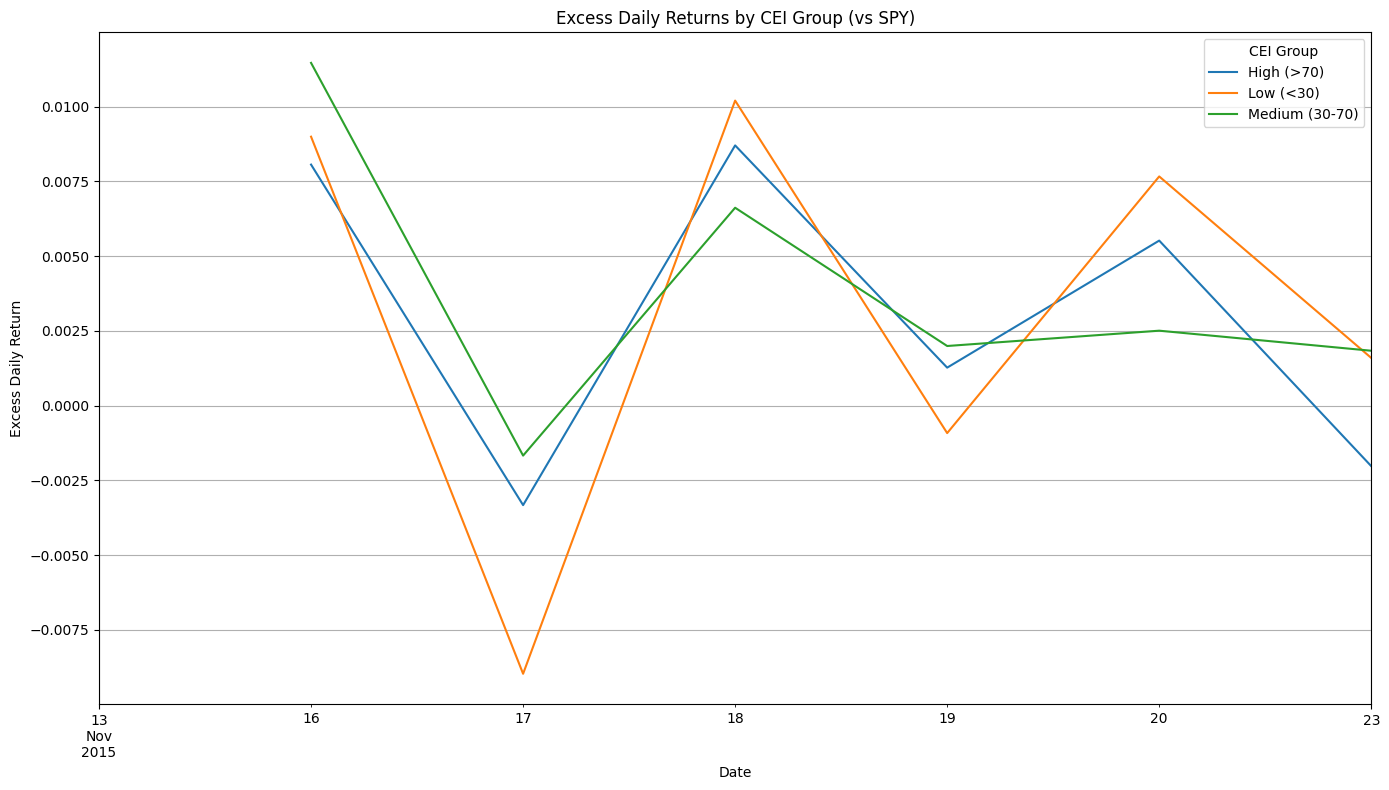

In [231]:
# Categorize CEI ratings into three groups
def classify_cei_group(rating):
    if rating < 30:
        return 'Low (<30)'
    elif rating > 70:
        return 'High (>70)'
    else:
        return 'Medium (30-70)'

# Create group column in the merged_returns DataFrame
merged_returns['CEI_Group'] = merged_returns['CEI_Rating'].apply(classify_cei_group)

# Aggregate daily returns by CEI group
grouped_returns = (
    merged_returns
    .groupby(['CEI_Group', 'date'])['daily_return']
    .mean()
    .reset_index()
)

# Pivot for plotting
pivot_group_returns = grouped_returns.pivot(index='date', columns='CEI_Group', values='daily_return')

# Join SPY returns
pivot_group_returns = pivot_group_returns.join(spy_returns, how='left')

# Compute excess returns
excess_group_returns = pivot_group_returns.subtract(pivot_group_returns['SPY'], axis=0)
excess_group_returns.drop(columns='SPY', inplace=True)

# Plot
fig, ax = plt.subplots(figsize=(14, 8))
excess_group_returns.plot(ax=ax)

ax.set_title("Excess Daily Returns by CEI Group (vs SPY)")
ax.set_xlabel("Date")
ax.set_ylabel("Excess Daily Return")
ax.legend(title="CEI Group", loc='upper right', fontsize='medium')
plt.grid(True)
plt.tight_layout()
plt.show()


In [230]:
from rapidfuzz import process, fuzz

def match_employer_to_cusip(cei_df, hrc_df, threshold=90):
    """
    Match CEI Employer names to HRC CUSIP values using fuzzy matching.

    Args:
        cei_df (pd.DataFrame): CEI dataframe with 'Employer'
        hrc_df (pd.DataFrame): HRC dataframe with 'EmployerName' and 'cusip'
        threshold (int): Minimum match score to accept

    Returns:
        pd.DataFrame: CEI dataframe with added 'Matched_CUSIP' and 'CUSIP_Match_Score'
    """
    hrc_names = hrc_df['EmployerName'].dropna().unique()

    matches = cei_df['Employer'].apply(
        lambda employer: process.extractOne(employer, hrc_names, scorer=fuzz.token_sort_ratio)
    )

    cei_df['Matched_EmployerName'] = matches.apply(lambda x: x[0] if x and x[1] >= threshold else None)
    cei_df['CUSIP_Match_Score'] = matches.apply(lambda x: x[1] if x else None)

    cusip_lookup = hrc_df.set_index('EmployerName')['cusip'].to_dict()
    cei_df['Matched_CUSIP'] = cei_df['Matched_EmployerName'].map(cusip_lookup)

    return cei_df

def compute_price_change_around_cei(stock_df, matched_cei_df, days_before=5, days_after=5):
    stock_df['date'] = pd.to_datetime(stock_df['date'])
    result_rows = []

    for _, row in matched_cei_df.dropna(subset=['Matched_Stock_Name']).iterrows():
        year = int(row['Year'])
        name = row['Matched_CUSIP']
        cei_release = pd.Timestamp(f"{year}-03-31")
        df_company = stock_df[stock_df['COMNAM'] == name].sort_values('date')
        before_date = cei_release - pd.Timedelta(days=days_before)
        after_date = cei_release + pd.Timedelta(days=days_after)
        price_before = df_company[df_company['date'] == before_date]['PRC'].values
        price_after = df_company[df_company['date'] == after_date]['PRC'].values

        if price_before.size > 0 and price_after.size > 0:
            ret = (price_after[0] - price_before[0]) / price_before[0]
            result_rows.append({
                'Employer': row['Employer'],
                'Matched_Stock_Name': name,
                'Year': year,
                'Price_Before': price_before[0],
                'Price_After': price_after[0],
                'Return': ret,
                'Match_Score': row['Match_Score'],
                'CEI_Rating': row.get('2018 \nCEI Rating', row.get('CEI Rating', None))
            })

    return pd.DataFrame(result_rows)



In [262]:
cei_df = cei_df_list[0]
cei_df = match_employer_to_cusip(cei_df, hrc_df, threshold=90)

In [180]:
cei_dates_df = utils.load_cei_release_dates(DATA_PATH+'cei_dates.csv')
start_date, end_date = utils.get_cei_date_range(2016,cei_dates_df)
stocks_date_range = utils.load_date_range_rows(STOCK_DATA_PATH,date_col='date',start_date=start_date,end_date=end_date)
stocks_date_range

/Users/guy/Projects/noni/pfp/notebooks/../src/pfp/utils.py:106: DtypeWarning: Columns (6,19,24,38,40) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(csv_path, chunksize=chunksize, parse_dates=[date_col]):
/Users/guy/Projects/noni/pfp/notebooks/../src/pfp/utils.py:106: DtypeWarning: Columns (6,9,19,22,24,38,40,49,57) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(csv_path, chunksize=chunksize, parse_dates=[date_col]):
/Users/guy/Projects/noni/pfp/notebooks/../src/pfp/utils.py:106: DtypeWarning: Columns (9,20,22,25,26,38,40,49,57) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(csv_path, chunksize=chunksize, parse_dates=[date_col]):
/Users/guy/Projects/noni/pfp/notebooks/../src/pfp/utils.py:106: DtypeWarning: Columns (9,22,38,40,49,57) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.rea

,PERMNO,date,NAMEENDT,SHRCD,EXCHCD,SICCD,NCUSIP,TICKER,COMNAM,SHRCLS,...,CFACPR,CFACSHR,OPENPRC,NUMTRD,RETX,vwretd,vwretx,ewretd,ewretx,sprtrn
0,10104,2015-11-13,NaN,11.0,1.0,7372,68389X10,ORCL,ORACLE CORP,NaN,...,1.0,1.0,38.48000,NaN,-0.034429,-0.009781,-0.009798,-0.005603,-0.005667,-0.011207
1,10104,2015-11-16,NaN,11.0,1.0,7372,68389X10,ORCL,ORACLE CORP,NaN,...,1.0,1.0,37.69000,NaN,0.021984,0.013738,0.013607,0.006320,0.006231,0.014903
2,10104,2015-11-17,NaN,11.0,1.0,7372,68389X10,ORCL,ORACLE CORP,NaN,...,1.0,1.0,38.23000,NaN,0.000262,-0.001359,-0.001519,-0.004298,-0.004380,-0.001339
3,10104,2015-11-18,NaN,11.0,1.0,7372,68389X10,ORCL,ORACLE CORP,NaN,...,1.0,1.0,38.19000,NaN,0.014949,0.015275,0.015198,0.009546,0.009417,0.016162
4,10104,2015-11-19,NaN,11.0,1.0,7372,68389X10,ORCL,ORACLE CORP,NaN,...,1.0,1.0,38.67000,NaN,0.008269,-0.000988,-0.001034,-0.000791,-0.000873,-0.001123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5160,93436,2015-11-17,NaN,11.0,3.0,9999,88160R10,TSLA,TESLA MOTORS INC,NaN,...,15.0,15.0,215.20000,19520.0,-0.001446,-0.001359,-0.001519,-0.004298,-0.004380,-0.001339
5161,93436,2015-11-18,NaN,11.0,3.0,9999,88160R10,TSLA,TESLA MOTORS INC,NaN,...,15.0,15.0,214.50000,24093.0,0.033037,0.015275,0.015198,0.009546,0.009417,0.016162
5162,93436,2015-11-19,NaN,11.0,3.0,9999,88160R10,TSLA,TESLA MOTORS INC,NaN,...,15.0,15.0,220.53999,23217.0,0.003302,-0.000988,-0.001034,-0.000791,-0.000873,-0.001123
5163,93436,2015-11-20,NaN,11.0,3.0,9999,88160R10,TSLA,TESLA MOTORS INC,NaN,...,15.0,15.0,223.49001,36680.0,-0.008070,0.003000,0.002884,0.002458,0.002416,0.003810


In [ ]:
    # stock_df['date'] = pd.to_datetime(stock_df['date'])
    # result_rows = []

    # for _, row in cei_df.dropna(subset=['Matched_CUSIP']).iterrows():
year = 2008 #int(row['Year'])
cusip = '88160R10' #row['Matched_CUSIP'][:-1]
cei_release = pd.Timestamp(f"2010-07-06")
df_company = stock_df[stock_df['CUSIP'] == cusip].sort_values('date')
before_date = cei_release - pd.Timedelta(days=days_before)
after_date = cei_release + pd.Timedelta(days=days_after)
price_before = df_company[df_company['date'] == before_date]['PRC'].values
price_after = df_company[df_company['date'] == after_date]['PRC'].values

if price_before.size > 0 and price_after.size > 0:
        ret = (price_after[0] - price_before[0]) / price_before[0]
        result_rows.append({
            'Employer': row['Employer'],
            'Matched_Stock_Name': cusip,
            'Year': year,
            'Price_Before': price_before[0],
            'Price_After': price_after[0],
            'Return': ret,
            'CEI_Rating': row.get('2008 CEI Rating', row.get('CEI Rating', None))
                })


In [235]:
from datetime import datetime
import pandas as pd

def get_trading_window_dates(dates, cei_release, days_before, days_after):
    pre_dates = [d for d in dates if d <= cei_release]
    post_dates = [d for d in dates if d >= cei_release]

    if len(pre_dates) < days_before or len(post_dates) <= days_after:
        return None, None

    start_date = pre_dates[-days_before]
    end_date = post_dates[days_after]
    return start_date, end_date

def extract_price_series(df_company, start_date, end_date):
    df_window = df_company[(df_company['date'] >= start_date) & (df_company['date'] <= end_date)]
    if df_window.empty:
        return None, None
    prices_str = ",".join(
        f"{d.date()}:{p:.2f}" for d, p in zip(df_window['date'], df_window['PRC']) if pd.notna(p)
    )
    return prices_str, df_window

def compute_cei_price_series(stock_df, cei_df, cei_release_date, days_before=5, days_after=5):
    """
    Master function to compute stock price strings for matched CEI companies around CEI release date.

    Args:
        stock_df (pd.DataFrame): Stock data with 'date', 'CUSIP', 'PRC'
        cei_df (pd.DataFrame): CEI data with 'Employer', 'Matched_CUSIP', 'Year'
        cei_release_date (str or pd.Timestamp): CEI report release date
        days_before (int): Number of trading days before release
        days_after (int): Number of trading days after release

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: 
            - price_series_df: CEI companies with price strings
            - filtered_stock_df: stock_df filtered to relevant rows
    """
    cei_release = pd.to_datetime(cei_release_date)
    stock_df = stock_df.copy()
    stock_df['date'] = pd.to_datetime(stock_df['date'])
    stock_df = stock_df.sort_values('date')

    result_rows = []
    relevant_stock_rows = []

    for _, row in cei_df.dropna(subset=['Matched_CUSIP']).iterrows():
        cusip = row['Matched_CUSIP']
        year = int(row['Year'])
        employer = row['Employer']

        df_company = stock_df[stock_df['CUSIP'].astype(str).str[:6] == cusip].sort_values('date')
        trading_days = df_company['date'].unique()

        start_date, end_date = get_trading_window_dates(trading_days, cei_release, days_before, days_after)
        if start_date is None or end_date is None:
            continue

        prices_str, df_window = extract_price_series(df_company, start_date, end_date)
        if prices_str is None:
            continue

        relevant_stock_rows.append(df_window)
        result_rows.append({
            'Employer': employer,
            'CUSIP': cusip,
            'Year': year,
            'Price_Series': prices_str
        })

    price_series_df = pd.DataFrame(result_rows)
    filtered_stock_df = pd.concat(relevant_stock_rows).reset_index(drop=True)

    return price_series_df, filtered_stock_df


In [236]:
price_series_df, filtered_stock_df = compute_cei_price_series(
    stock_df,
    cei_df,
    "2008-09-02",
    days_before=5,
    days_after=5
)


ValueError: No objects to concatenate

In [219]:
cei_release_date ="2008-09-02"

In [ ]:

# Show plot and regression results
plot_return_vs_rating(price_change_df)
regression_result = regression_analysis(price_change_df)
regression_result
